
<div style="
    background-color: #f7f7f7;
    background-image: url(''), url('') ;
    background-position: left bottom, right top;
    background-repeat: no-repeat,  no-repeat;
    background-size: auto 60px, auto 160px;
    border-radius: 5px;
    box-shadow: 0px 3px 1px -2px rgba(0, 0, 0, 0.2), 0px 2px 2px 0px rgba(0, 0, 0, 0.14), 0px 1px 5px 0px rgba(0,0,0,.12);">

<h1 style="
    color: #2a4cdf;
    font-style: normal;
    font-size: 2.25rem;
    line-height: 1.4em;
    font-weight: 600;
    padding: 30px 200px 0px 30px;"> 
        Perovscribe Evals</h1>

<p style="
    line-height: 1.4em;
    padding: 30px 200px 0px 30px;">
    This notebook runs through the analysis of the Perovscribe extraction pipeline to compute extraction performance metrics
</p>

</div>

## Overview

This notebook evaluates the performance of the Perovscribe extraction pipeline by comparing extracted data against a ground truth dataset. The evaluation covers multiple Large Language Models (LLMs) and compares their extraction performance across different data fields.


### Evaluation Methodology

The evaluation uses a **confusion matrix** approach:
- **True Positives (TP)**: Fields correctly extracted and matching ground truth
- **False Positives (FP)**: Fields extracted but not present in ground truth
- **False Negatives (FN)**: Fields in ground truth but not extracted

**Metrics calculated**:
- **Precision** = TP / (TP + FP) - Measures extraction accuracy
- **Recall** = TP / (TP + FN) - Measures extraction completeness
- **F1 Score** = 2 × (Precision × Recall) / (Precision + Recall) - Harmonic mean of precision and recall


## Setup and Evaluations

The evaluation is done by comparing the extracted data to a ground truth dataset.
Sometimes, the scoring will use an LLM to score the extracted data.

For this reason, we need API keys for the LLMs we are using.

### Imports & Setup

In [ ]:
# --- Imports ---
import json
import os
from importlib.resources import files
from math import pi
from pathlib import Path


import dabest
import litellm
from litellm.caching.caching import Cache

litellm.cache = Cache(type='disk')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from tqdm import tqdm

# Third-party libraries
from dotenv import load_dotenv


# Internal modules
# Ensure 'perovscribe' is accessible in the repo structure
from perovscribe.pipeline import ExtractionPipeline
from plotly_theme import register_template, set_defaults, MODEL_COLORS

# --- Configuration & Theme ---
load_dotenv()  # Loads .env if present
register_template()
set_defaults()

plt.rcParams.update(
    {
        'font.family': 'Arial',
        'font.size': 10,
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 12,
        'axes.linewidth': 1,
        'axes.edgecolor': 'black',
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'grid.color': 'lightgray',
        'grid.linewidth': 0.5,
        'axes.grid': False,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.facecolor': 'white',
    }
)
# Define Paths (Use relative paths for reproducibility!)
DATA_DIR = files('perovscribe').joinpath('data')
EXTRACTIONS_DIR = DATA_DIR / 'extractions'
GROUND_TRUTH_DIR = DATA_DIR / 'ground_truth' / 'test'
DEV_DIR = DATA_DIR / 'ground_truth' / 'dev'
EXPERTS_DIR = EXTRACTIONS_DIR / 'humans' / 'Consensus'
# MODEL_COLORS is imported from plotly_theme (single source of truth for colors)

Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:00<00:00, 33.31it/s]


Numba compilation complete!


15:36:14 - LiteLLM:ERROR: redis_cache.py:178 - Error connecting to Sync Redis client


15:36:14 - LiteLLM:ERROR: redis_cache.py:1081 - LiteLLM Redis Cache PING: - Got exception from REDIS : Error 61 connecting to 127.0.0.1:6379. Connect call failed ('127.0.0.1', 6379).


In [2]:
# ============================================================================
# COUNT DEVICES IN TEST AND VALIDATION SETS
# ============================================================================


def count_devices_in_directory(ground_truth_dir):
    """
    Count the number of devices in a ground truth directory.

    Each JSON file contains a "cells" list, where each element represents a device.
    This function counts the length of the "cells" list in each file.

    Args:
        ground_truth_dir: Path to ground truth directory

    Returns:
        dict with 'files' (number of JSON files), 'total_devices' (sum of len(cells)),
        and 'papers' (number of unique papers/DOIs)
    """
    if not ground_truth_dir.exists():
        return {'files': 0, 'total_devices': 0, 'papers': 0}

    json_files = list(ground_truth_dir.glob('*.json'))
    num_files = len(json_files)

    # Count devices from "cells" list in each JSON file
    total_devices = 0
    papers_with_devices = set()

    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            # Count devices: length of "cells" list
            if isinstance(data, dict) and 'cells' in data:
                devices_in_file = len(data['cells'])
                total_devices += devices_in_file

                # Extract DOI from filename (format: DOI.json)
                # Filename format is like "10.1002--adma.202305822.json"
                doi = json_file.stem.replace('--', '/')
                papers_with_devices.add(doi)
            else:
                # Fallback: if structure is unexpected, count as 1 device
                total_devices += 1

        except (json.JSONDecodeError, KeyError, TypeError) as e:
            # If file can't be parsed, skip it
            print(f'Warning: Could not parse {json_file.name}: {e}')

    return {
        'files': num_files,
        'total_devices': total_devices,
        'papers': len(papers_with_devices) if papers_with_devices else num_files,
    }


# Count devices in test and validation sets
test_counts = count_devices_in_directory(GROUND_TRUTH_DIR)
dev_counts = count_devices_in_directory(DEV_DIR)

print('=' * 60)
print('DEVICE COUNTS IN DATASETS')
print('=' * 60)
print(f'\nTest Set:')
print(f'  Number of files: {test_counts["files"]}')
print(f'  Estimated devices: {test_counts["total_devices"]}')
print(f'  Unique papers: {test_counts["papers"]}')

print(f'\nValidation Set (dev):')
print(f'  Number of files: {dev_counts["files"]}')
print(f'  Estimated devices: {dev_counts["total_devices"]}')
print(f'  Unique papers: {dev_counts["papers"]}')

print(f'\nTotal:')
print(f'  Files: {test_counts["files"] + dev_counts["files"]}')
print(f'  Devices: {test_counts["total_devices"] + dev_counts["total_devices"]}')
print(f'  Papers: {test_counts["papers"] + dev_counts["papers"]}')
print('=' * 60)

DEVICE COUNTS IN DATASETS

Test Set:
  Number of files: 20
  Estimated devices: 101
  Unique papers: 20

Validation Set (dev):
  Number of files: 10
  Estimated devices: 35
  Unique papers: 10

Total:
  Files: 30
  Devices: 136
  Papers: 30


### Model Configurations

In [3]:
# Define model metadata: Display Names, Colors, and Token Costs (per 1M tokens)
# Prices are examples; verify current API pricing.
# Colors are obtained from MODEL_COLORS (imported from plotly_theme)
MODEL_CONFIG = {
    'gpt-5-2025-08-07': {
        'name': 'GPT-5',
        'color': MODEL_COLORS['GPT-5'],
    },
    'gpt-5-mini-2025-08-07': {
        'name': 'GPT-5 Mini',
        'color': MODEL_COLORS['GPT-5 Mini'],
    },
    'claude-opus-4-20250514': {
        'name': 'Claude Opus 4',
        'color': MODEL_COLORS['Claude Opus 4'],
    },
    'claude-sonnet-4-20250514': {
        'name': 'Claude Sonnet 4',
        'color': MODEL_COLORS['Claude Sonnet 4'],
    },
    'claude-opus-4-1-20250805': {
        'name': 'Claude Opus 4.1',
        'color': MODEL_COLORS['Claude Opus 4.1'],
    },
    'gpt-4.1-2025-04-14': {
        'name': 'GPT-4.1',
        'color': MODEL_COLORS['GPT-4.1'],
    },
    'gpt-4o-2024-08-06': {
        'name': 'GPT-4o',
        'color': MODEL_COLORS['GPT-4o'],
    },
}

## Evaluations

##### Evals Code

In [ ]:
# ============================================================================
# DATA LOADING AND MODEL EVALUATION
# ============================================================================

all_metrics = {}  # model_name -> paper_doi -> {field: score}
all_precs_and_recalls = {}

# Evaluate all models
for model_dir in tqdm(
    EXTRACTIONS_DIR.iterdir(), total=len([d for d in EXTRACTIONS_DIR.iterdir()])
):
    if not model_dir.is_dir() or model_dir == 'humans':
        continue

    model_name = model_dir.name
    print(f'Evaluating model: {model_name}')

    pipeline = ExtractionPipeline(
        model_name=model_name,
        preprocessor='pymupdf',
        postprocessor='NONE',
        cache_dir='',
        use_cache=True,
    )
    model_metrics, avg_recalls, avg_precisions = pipeline._evaluate_multiple(
        model_dir, GROUND_TRUTH_DIR
    )

    all_precs_and_recalls[model_name] = {
        'precision': avg_precisions,
        'recall': avg_recalls,
    }
    all_metrics[model_name] = model_metrics

# Rename models to readable names
model_name_map = {
    'claude-opus-4-1-20250805': 'Claude Opus 4.1',
    'claude-opus-4-20250514': 'Claude Opus 4',
    'claude-sonnet-4-20250514': 'Claude Sonnet 4',
    'gpt-4.1-2025-04-14': 'GPT-4.1',
    'gpt-4o-2024-08-06': 'GPT-4o',
    'gpt-5-2025-08-07': 'GPT-5',
    'gpt-5-mini-2025-08-07': 'GPT-5 Mini',
}

all_metrics = {model_name_map.get(k, k): v for k, v in all_metrics.items()}

##### Helper Functions

In [5]:
# ============================================================================
# HELPER FUNCTIONS (DATAFRAME VERSION)
# ============================================================================


def metrics_to_dataframe(metrics_dict):
    """
    Convert nested metrics dictionary to a flat DataFrame.

    Returns:
        DataFrame with columns: model, paper, field, TP, FP, FN
    """
    rows = []
    for model, papers in metrics_dict.items():
        for paper, fields in papers.items():
            for field, values in fields.items():
                if isinstance(values, dict):
                    rows.append(
                        {
                            'model': model,
                            'paper': paper,
                            'field': field,
                            'TP': values.get('TP', 0.0),
                            'FP': values.get('FP', 0.0),
                            'FN': values.get('FN', 0.0),
                        }
                    )
    return pd.DataFrame(rows)


def add_field_categories(df):
    """Add aggregation category for each field."""

    def categorize(field):  # noqa: PLR0911
        if field.endswith(':unit'):
            return 'units'
        field_lower = field.lower()
        if 'composition' in field_lower:
            return 'composition'
        if 'stability' in field_lower:
            return 'stability'
        if 'deposition' in field_lower:
            return 'deposition'
        if 'layers' in field_lower:
            return 'layers'
        if 'light' in field_lower:
            return 'light'
        # Clean up individual fields
        if any(
            x in field
            for x in ['averaged_quantities', 'number_devices', 'encapsulated']
        ):
            return None
        return field.replace('_', ' ').split(':value')[0]

    df['category'] = df['field'].apply(categorize)
    return df[df['category'].notna()]


def calculate_metrics(df, metric_type='recall'):
    """
    Calculate precision or recall for each row.

    Args:
        df: DataFrame with TP, FP, FN columns
        metric_type: 'recall' or 'precision'
    """
    if metric_type == 'recall':
        df['score'] = df.apply(
            lambda row: row['TP'] / (row['TP'] + row['FN'])
            if (row['TP'] + row['FN']) > 0
            else np.nan,
            axis=1,
        )
    else:  # precision
        df['score'] = df.apply(
            lambda row: row['TP'] / (row['TP'] + row['FP'])
            if (row['TP'] + row['FP']) > 0
            else np.nan,
            axis=1,
        )
    return df

## Visualize

#### Overall Performance

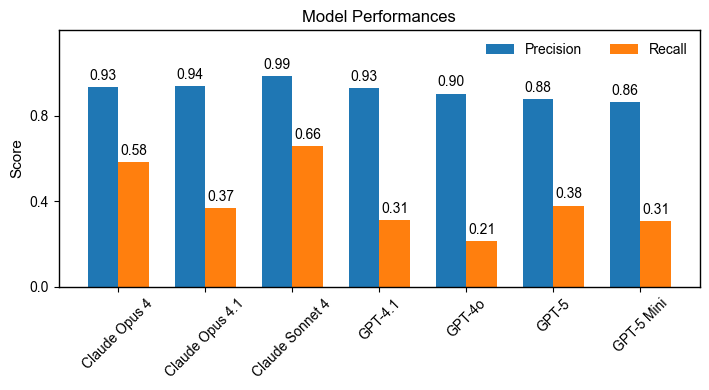

In [6]:
# ============================================================================
# BAR CHART: OVERALL MODEL PERFORMANCE (DATAFRAME VERSION)
# ============================================================================

# Calculate overall metrics per model
df = metrics_to_dataframe(all_metrics)

df_doi = (
    df.groupby(['model', 'paper'])
    .agg({'TP': 'sum', 'FP': 'sum', 'FN': 'sum'})
    .reset_index()
)

overall = df_doi.groupby('model').sum().reset_index()
overall['precision'] = overall['TP'] / (overall['TP'] + overall['FP'])
overall['recall'] = overall['TP'] / (overall['TP'] + overall['FN'])


# Plot
x = np.arange(len(overall))
width = 0.35

overall_performance_fig, ax = plt.subplots(figsize=(7.2, 4))
rects1 = ax.bar(x - width / 2, overall['precision'], width, label='Precision')
rects2 = ax.bar(x + width / 2, overall['recall'], width, label='Recall')

ax.set_ylabel('Score')
ax.set_title('Model Performances')
ax.set_xticks(x)
ax.set_xticklabels(overall['model'], rotation=45)
ax.set_yticks(np.arange(0, 1.1, 0.4))
ax.set_yticklabels([f'{y:.1f}' for y in np.arange(0, 1.1, 0.4)])
ax.set_ylim(0, 1.2)
ax.legend(loc='upper right', ncol=2, frameon=False)

# Add value labels
for rects, values in [(rects1, overall['precision']), (rects2, overall['recall'])]:
    for rect, val in zip(rects, values):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.0,
            height + 0.02,
            f'{val:.2f}',
            ha='center',
            va='bottom',
        )

plt.tight_layout()
overall_performance_fig.savefig('overall_performance_bars.pdf')

#### Radar Plot: Recall/Precision per field

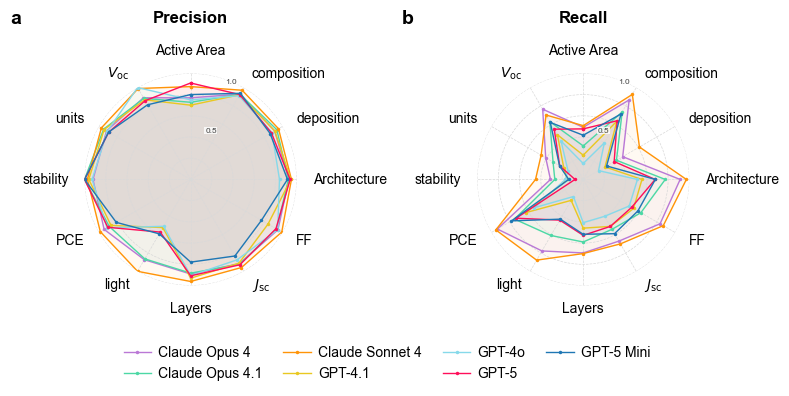

In [10]:
# Convert to DataFrame and calculate precisions
df = metrics_to_dataframe(all_metrics)
df = add_field_categories(df)
df_recall = df.copy()
df_precision = df.copy()
df_precision = calculate_metrics(df_precision, metric_type='precision')
df_recall = calculate_metrics(df_recall, metric_type='recall')

# Aggregate by model and category
aggregated_precision = (
    df_precision.groupby(['model', 'category'])['score'].mean().reset_index()
)
aggregated_recall = (
    df_recall.groupby(['model', 'category'])['score'].mean().reset_index()
)

# Pivot for radar plot
pivot_precision = aggregated_precision.pivot(
    index='model', columns='category', values='score'
).fillna(0)
pivot_recall = aggregated_recall.pivot(
    index='model', columns='category', values='score'
).fillna(0)


# Prepare Fields
fields = sorted(pivot_precision.columns)
num_fields = len(fields)
angles = [n / float(num_fields) * 2 * pi for n in range(num_fields)]
angles += angles[:1]  # Close the loop


# Formatter
def format_field_name(field):
    field_map = {
        'pce': 'PCE',
        'jsc': r'$J_\mathrm{sc}$',
        'ff': 'FF',
        'voc': r'$V_\mathrm{oc}$',
        'active area': 'Active Area',
        'layers': 'Layers',
        'device architecture': 'Architecture',
    }
    return field_map.get(field.lower(), field)


field_labels = [format_field_name(f) for f in fields]

# ============================================================================
# 3. PLOTTING FUNCTION
# ============================================================================


def draw_radar(ax, pivot_df, title, letter_label, ylim=(0, 1)):
    # A. Setup Grid & Spines
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.spines['polar'].set_visible(False)
    # Very light, thin grid
    ax.grid(color='#D9D9D9', linestyle='--', linewidth=0.5)

    # B. Plot Data (Thinner lines for clarity)
    for model_name in pivot_df.index:
        scores = pivot_df.loc[model_name, fields].tolist()
        values = scores + [scores[0]]
        color = MODEL_COLORS.get(model_name, '#333333')

        ax.plot(
            angles,
            values,
            linewidth=1.0,  # Nature standard line width
            linestyle='-',
            marker='o',
            markersize=2.5,  # Small, crisp markers
            markeredgewidth=0,  # No border on markers for cleanliness
            label=model_name,
            color=color,
        )

        # Extremely subtle fill to keep grid visible
        ax.fill(angles, values, color=color, alpha=0.05)

    # C. Smart Labels (Compact & Aligned)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])

    # Distance: Closer to center because fonts are smaller (1.15 is sufficient now)
    label_distance = 1.15

    for angle, label in zip(angles[:-1], field_labels):
        angle_norm = angle % (2 * np.pi)

        if np.isclose(angle_norm, 0):  # 12 o'clock
            ha, va = 'center', 'bottom'
        elif 0 < angle_norm < np.pi:  # Right
            ha, va = 'left', 'center'
        elif np.isclose(angle_norm, np.pi):  # 6 o'clock
            ha, va = 'center', 'top'
        else:  # Left
            ha, va = 'right', 'center'

        # Font size 7pt (standard text)
        ax.text(
            angle,
            label_distance,
            label,
            horizontalalignment=ha,
            verticalalignment=va,
            color='black',
        )

    # D. Y-Axis (Radial) - Minimalist
    ax.set_ylim(ylim)
    ax.set_yticklabels([])

    # Minimal ticks: Only show max and mid-point to reduce clutter
    mid_val = (ylim[0] + ylim[1]) / 2
    ticks = [mid_val, ylim[1]]
    r_angle = np.deg2rad(22.5)  # Draw ticks at 22.5 deg to avoid crossing vertical axis

    for y in ticks:
        ax.text(
            r_angle,
            y,
            f'{y:.1f}',
            color='#404040',
            size=6,
            ha='center',
            va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.5),
        )

    ax.set_title(title, y=1.2, fontweight='bold', color='black')

    ax.text(
        -0.3,
        1.3,
        letter_label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='right',
        color='black',
    )


# ============================================================================
# 4. GENERATE FIGURE
# ============================================================================

# Width: 7.2 inches (183mm) exactly
# Height: 3.5 inches (approx 89mm) - compact aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.5), subplot_kw={'polar': True})

# Draw Plots
draw_radar(ax1, pivot_precision, 'Precision', 'a', ylim=(0.0, 1.0))
draw_radar(ax2, pivot_recall, 'Recall', 'b', ylim=(0.0, 1.0))

# Shared Legend
handles, labels = ax1.get_legend_handles_labels()
# Very compact legend
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,  # 4 columns to be wider/flatter
    frameon=False,
    columnspacing=1.5,
    handletextpad=0.5,
)

# Tight layout with manual adjustments for the legend space
plt.subplots_adjust(
    top=0.82,
    bottom=0.20,  # Space for legend
    left=0.08,
    right=0.92,
    wspace=0.85,
)

# Save as PDF (Vector format required by Nature)
plt.savefig('performance_radar_plot.pdf', dpi=300, format='pdf')

### Comparison with Experts

#### Evaluation Code

In [ ]:
pipeline = ExtractionPipeline(
    model_name='Consensus',
    preprocessor='pymupdf',
    postprocessor='NONE',
    cache_dir='',
    use_cache=True,
)
authors_metrics, authors_recalls, authors_precisions = pipeline._evaluate_multiple(
    EXPERTS_DIR, GROUND_TRUTH_DIR
)

In [12]:
all_metrics['Consensus'] = authors_metrics
experts_included_df = metrics_to_dataframe(all_metrics)

# 1. Get the set of papers that appear with model == "Consensus"
expert_papers = set(
    experts_included_df.loc[experts_included_df['model'] == 'Consensus', 'paper']
)

# 2. Filter the DataFrame
filtered_df = experts_included_df[
    (experts_included_df['model'] == 'Consensus')
    | (
        (experts_included_df['model'] != 'Consensus')
        & (experts_included_df['paper'].isin(expert_papers))
    )
]

In [13]:
# Group by paper and model, sum TP and FP
micro_precision_df = (
    filtered_df.groupby(['paper', 'model'])[['TP', 'FP']].sum().reset_index()
)

# Compute micro-precision
micro_precision_df['precision'] = micro_precision_df['TP'] / (
    micro_precision_df['TP'] + micro_precision_df['FP']
)

<Figure size 640x480 with 0 Axes>

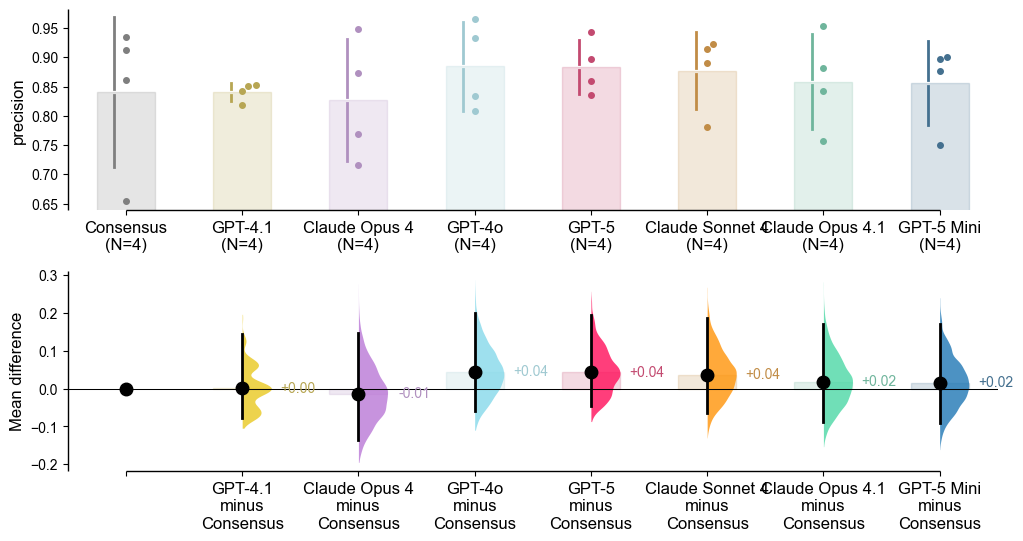

In [14]:
# Only select the papers where both LLMs and experts exist
papers_with_both = micro_precision_df['paper'].value_counts()
papers_with_both = papers_with_both[papers_with_both > 1].index
df_plot = micro_precision_df[micro_precision_df['paper'].isin(papers_with_both)]

# Pivot data so each row is a DOI and each column is a model
df_pivot = df_plot.pivot(
    index='paper', columns='model', values='precision'
).reset_index()

# Melt data for dabest
df_melt = df_pivot.melt(id_vars='paper', var_name='model', value_name='precision')

# Create a dabest object using authors as the control
dabest_data = dabest.load(
    data=df_melt,
    x='model',
    y='precision',
    idx=(
        'Consensus',
        'GPT-4.1',
        'Claude Opus 4',
        'GPT-4o',
        'GPT-5',
        'Claude Sonnet 4',
        'Claude Opus 4.1',
        'GPT-5 Mini',
    ),
)

# Plot mean difference against authors
plt.figure()
mean_fig = dabest_data.mean_diff.plot(
    raw_marker_size=4,
    custom_palette=MODEL_COLORS,
)

#### Overlapping extractions spider plots

In [ ]:
human_metrics = {}  # model_name -> paper_doi -> {field: score}
human_precs_and_recalls = {}

HUMANS_DIR = EXTRACTIONS_DIR / 'humans'
DEV_DIR = DATA_DIR / 'ground_truth' / 'dev'
# Evaluate all models
for model_dir in HUMANS_DIR.iterdir():
    if not model_dir.is_dir():
        continue

    model_name = model_dir.name
    print(f'Evaluating model: {model_name}')

    pipeline = ExtractionPipeline(
        model_name=model_name,
        preprocessor='pymupdf',
        postprocessor='NONE',
        cache_dir='',
        use_cache=True,
    )
    model_metrics, avg_recalls, avg_precisions = pipeline._evaluate_multiple(
        model_dir, DEV_DIR
    )

    human_precs_and_recalls[model_name] = {
        'precision': avg_precisions,
        'recall': avg_recalls,
    }
    human_metrics[model_name] = model_metrics

sonnet_4_metrics, s_rec, s_prec = pipeline._evaluate_multiple(
    EXTRACTIONS_DIR / 'claude-sonnet-4-20250514/', DEV_DIR
)
human_metrics['Claude Sonnet 4'] = sonnet_4_metrics

##### What dois match across our extractions

In [17]:
from collections import defaultdict

doi_to_groups = defaultdict(list)

for group, dois in human_metrics.items():
    for doi in dois:
        doi_to_groups[doi].append(group)

print('DOI matches across groups:\n')
for doi, groups in doi_to_groups.items():
    if len(groups) > 1:
        print(f'{doi} -> {", ".join(groups)}')

DOI matches across groups:

10.1021--acs.chemmater.8b01521.json -> Consensus, Kit, Seal, Robin, Claude Sonnet 4
10.1021--acsaem.9b01928.json -> Consensus, Bee, Panda, Seal, Dove, Claude Sonnet 4
10.1002--adfm.201904856.json -> Consensus, Bee, Fox, Kit, Claude Sonnet 4
10.1039--c7nr04692h.json -> Consensus, Bear, Kit, Dove, Claude Sonnet 4
10.1002--adma.202302143.json -> Consensus, Bee, Robin, Claude Sonnet 4
10.1002--solr.201900370.json -> Consensus, Bear, Lark, Kit, Claude Sonnet 4
10.1039--c5dt02388b.json -> Consensus, Bear, Kit, Otto, Claude Sonnet 4
10.1016--j.nanoen.2016.05.023.json -> Consensus, Bear, Panda, Lark, Seal, Dove, Hawk, Claude Sonnet 4
10.1002--adfm.201500335.json -> Consensus, Bee, Panda, Dove, Claude Sonnet 4
10.1016--j.matlet.2016.07.004.json -> Consensus, Bear, Lark, Dove, Claude Sonnet 4


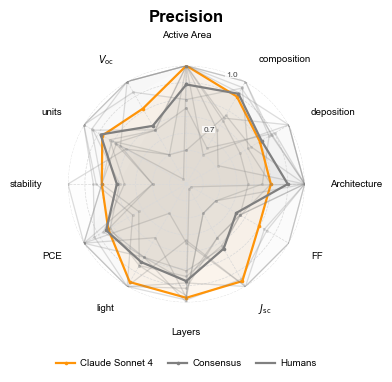

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from matplotlib.lines import Line2D

# ---------------------------------------------------------------------
# 1) DATA PREP (same as yours)
# ---------------------------------------------------------------------
df = metrics_to_dataframe(human_metrics)
df = add_field_categories(df)
df = calculate_metrics(df, metric_type='precision')

aggregated = df.groupby(['model', 'category'])['score'].mean().reset_index()
pivot_df = aggregated.pivot(index='model', columns='category', values='score').fillna(0)

fields = sorted(pivot_df.columns)
num_fields = len(fields)
angles = [n / float(num_fields) * 2 * pi for n in range(num_fields)]
angles += angles[:1]  # close loop


# Field name formatter (same style as template)
def format_field_name(field):
    field_map = {
        'pce': 'PCE',
        'jsc': r'$J_\mathrm{sc}$',
        'ff': 'FF',
        'voc': r'$V_\mathrm{oc}$',
        'active area': 'Active Area',
        'layers': 'Layers',
        'device architecture': 'Architecture',
    }
    return field_map.get(str(field).lower(), field)


field_labels = [format_field_name(f) for f in fields]


# ---------------------------------------------------------------------
# 2) PLOTTING (Nature-like style, like subfigure a)
# ---------------------------------------------------------------------
def draw_radar_precision_like_a(
    ax,
    pivot_df,
    title='Precision',
    ylim=(0.3, 1.0),
    highlight_models=('Consensus', 'Claude Sonnet 4'),
):
    # A) Grid & spines
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.spines['polar'].set_visible(False)
    ax.grid(color='#D9D9D9', linestyle='--', linewidth=0.5)

    # B) Plot data (highlight vs dim)
    for model_name in pivot_df.index:
        scores = pivot_df.loc[model_name, fields].tolist()
        values = scores + [scores[0]]

        if model_name in highlight_models:
            color = MODEL_COLORS.get(model_name, '#333333')
            line_alpha = 1.0
            fill_alpha = 0.06
            lw = 1.6
            ms = 2.6
        else:
            color = 'gray'
            line_alpha = 0.25
            fill_alpha = 0.015
            lw = 0.9
            ms = 2.2

        ax.plot(
            angles,
            values,
            linewidth=lw,
            linestyle='-',
            marker='o',
            markersize=ms,
            markeredgewidth=0,
            color=color,
            alpha=line_alpha,
            label=model_name,
        )
        ax.fill(angles, values, color=color, alpha=fill_alpha)

    # C) Axis limits
    ax.set_ylim(ylim)

    # D) X labels (manual placement like template)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])

    label_distance = 1.15
    for angle, label in zip(angles[:-1], field_labels):
        angle_norm = angle % (2 * np.pi)

        if np.isclose(angle_norm, 0):  # 12 o'clock
            ha, va = 'center', 'bottom'
        elif 0 < angle_norm < np.pi:  # right half
            ha, va = 'left', 'center'
        elif np.isclose(angle_norm, np.pi):  # 6 o'clock
            ha, va = 'center', 'top'
        else:  # left half
            ha, va = 'right', 'center'

        ax.text(
            angle,
            label_distance,
            label,
            ha=ha,
            va=va,
            color='black',
            fontsize=7,
        )

    # E) Radial labels (minimal, with small white bbox like template)
    ax.set_yticklabels([])
    mid_val = (ylim[0] + ylim[1]) / 2
    ticks = [mid_val, ylim[1]]
    r_angle = np.deg2rad(22.5)

    for y in ticks:
        ax.text(
            r_angle,
            y,
            f'{y:.1f}',
            color='#404040',
            size=6,
            ha='center',
            va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.5),
        )

    ax.set_title(title, y=1.15, fontweight='bold', color='black')


# ---------------------------------------------------------------------
# 3) FIGURE + LEGEND (compact)
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(7.2, 3.5))
ax = plt.subplot(111, polar=True)

draw_radar_precision_like_a(
    ax,
    pivot_df,
    title='Precision',
    ylim=(0.3, 1.0),
    highlight_models=('Consensus', 'Claude Sonnet 4'),
)

# Keep legend similar to your intent: only highlights + "Humans" entry
humans_legend_handle = Line2D(
    [0], [0], color='gray', linewidth=1.6, alpha=1.0, label='Humans'
)

handles, labels = ax.get_legend_handles_labels()
allowed = {'Consensus', 'Claude Sonnet 4'}
filtered = [(h, l) for h, l in zip(handles, labels) if l in allowed]

if filtered:
    handles, labels = zip(*filtered)
    handles, labels = list(handles), list(labels)
else:
    handles, labels = [], []

handles += [humans_legend_handle]
labels += ['Humans']

fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=3,
    frameon=False,
    columnspacing=1.5,
    handletextpad=0.5,
    fontsize=7,
)

plt.subplots_adjust(top=0.82, bottom=0.22, left=0.08, right=0.92)
plt.tight_layout()
plt.savefig('human_precision_radar.pdf', dpi=300, format='pdf')